In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.core.display import HTML
import sklearn as sklearn
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.dpi'] = 200

In [12]:
columns = [
    "unit number", "time, in cycles", "operational setting 1", "operational setting 2", 
    "operational setting 3", "sensor measurement 1", "sensor measurement 2",
    *[f"sensor measurement {i}" for i in range(3, 27)]
]


In [196]:
train = pd.read_csv('train_FD001.txt', names = columns, delimiter = " ")
test = pd.read_csv('test_FD001.txt', names = columns, delimiter = " ")
y = pd.read_csv('RUL_FD001.txt', header=None)
y.index = y.index.map(lambda x: x + 1)
y

,0
1,112
2,98
3,69
4,82
5,91
...,...
96,137
97,82
98,59
99,117


In [14]:
train.agg(["mean","max","min","count"])

,unit number,"time, in cycles",operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21,sensor measurement 22,sensor measurement 23,sensor measurement 24,sensor measurement 25,sensor measurement 26
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,14.62,...,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN,NaN,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,14.62,...,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,14.62,...,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN,NaN,NaN,NaN
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,20631.00,...,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0,0.0,0.0,0.0


In [15]:
traincleaned = train.drop(columns=["unit number","time, in cycles","operational setting 3","sensor measurement 1","sensor measurement 5","sensor measurement 10","sensor measurement 16","sensor measurement 18","sensor measurement 19","sensor measurement 22","sensor measurement 23","sensor measurement 24","sensor measurement 25","sensor measurement 26"])
testcleaned = test.drop(columns=["unit number","time, in cycles","operational setting 3","sensor measurement 1","sensor measurement 5","sensor measurement 10","sensor measurement 16","sensor measurement 18","sensor measurement 19","sensor measurement 22","sensor measurement 23","sensor measurement 24","sensor measurement 25","sensor measurement 26"])

In [193]:
y

,0
1,112
2,98
3,69
4,82
5,91
...,...
96,137
97,82
98,59
99,117


In [200]:
def create_RUL_dataframe(df):
    train_grouped_by_unit = df.groupby(by='unit number')
    max_time_cycles = train_grouped_by_unit['time, in cycles'].max()

 
    df['max_time_cycle'] = df['unit number'].map(max_time_cycles)
    df["RUL"] = df["max_time_cycle"] - df['time, in cycles']
    
    rul = df[['RUL']].copy()

    return rul

def create_RULy_dataframe(df, y):

    # Ensure 'unit number' is integer type
    df['unit number'] = df['unit number'].astype(int)

    # Group by 'unit number' and find the max of 'time, in cycles'
    train_grouped_by_unit = df.groupby(by='unit number')
    max_time_cycles = train_grouped_by_unit['time, in cycles'].max()

    # Map max_time_cycles to df
    df['max_time_cycle'] = df['unit number'].map(max_time_cycles)

    # Map y values to df and ensure it's a Series
    unit_number_mapped = df['unit number'].apply(lambda x: y.loc[x]).squeeze()

    # Calculate time_cycle_diff as a Series
    time_cycle_diff = df['max_time_cycle'] - df['time, in cycles']

    # Calculate RUL
    df["RUL"] = unit_number_mapped + time_cycle_diff

    # Return the RUL column as a DataFrame
    rul = df[['RUL']].copy()
    return rul



yTrain = create_RUL_dataframe(train)
yTest = create_RULy_dataframe(test, y)

In [100]:
scaler = StandardScaler()
trainScaled = scaler.fit_transform(traincleaned)
testScaled = scaler.transform(testcleaned)
trainScaled = pd.DataFrame(trainScaled, columns=traincleaned.columns, index=traincleaned.index)
testScaled = pd.DataFrame(testScaled, columns=testcleaned.columns, index=testcleaned.index)

In [129]:
X = sm.add_constant(trainScaled)
model = sm.OLS(yTrain, X).fit()
st = Stargazer([model])
HTML(st.render_html())

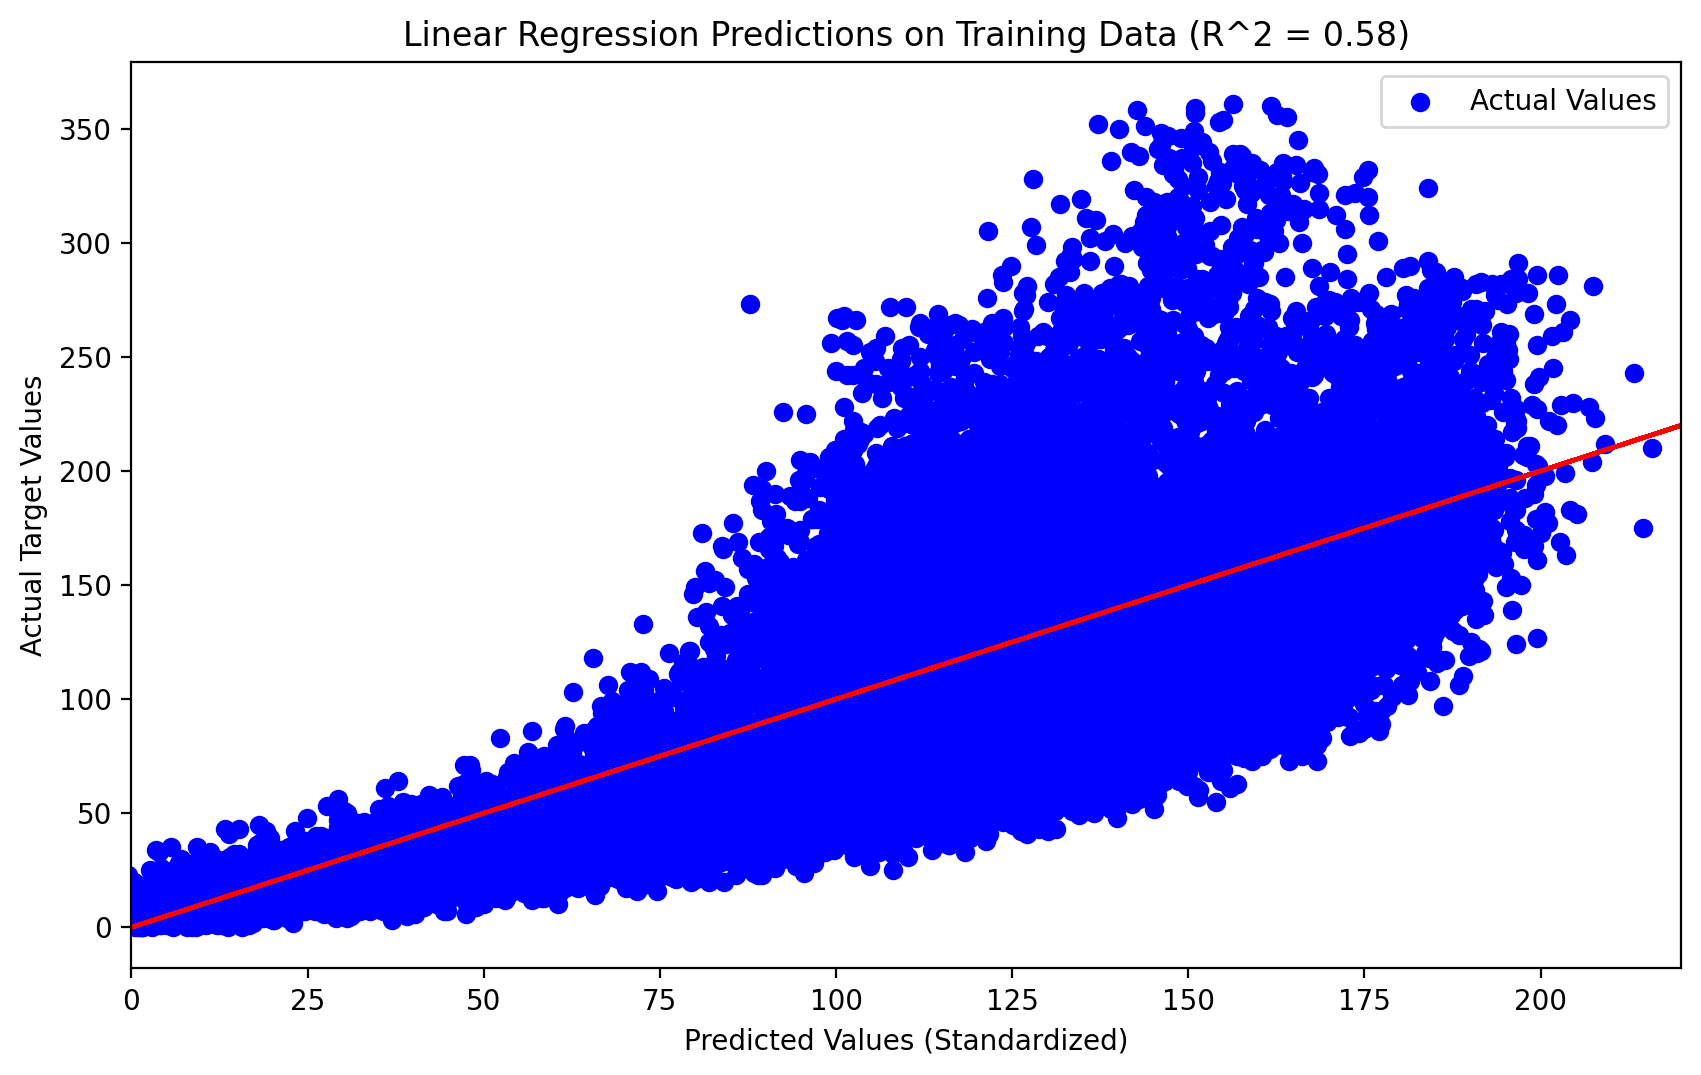

0.5795961126406293


In [202]:
r_squared = .58
plt.figure(figsize=(10, 6))
plt.scatter(model.predict(X), yTrain, color='blue', label='Actual Values')
plt.plot(yTrain.values, yTrain.values, color='red')  # Line for perfect predictions

plt.title(f'Linear Regression Predictions on Training Data (R^2 = {r_squared:.2f})')
plt.xlabel('Predicted Values (Standardized)')
plt.ylabel('Actual Target Values')
plt.legend()
plt.xlim(0, 220)  # Setting limit for x-axis
plt.show()
print(r2_score(yTrain, model.predict(X)))

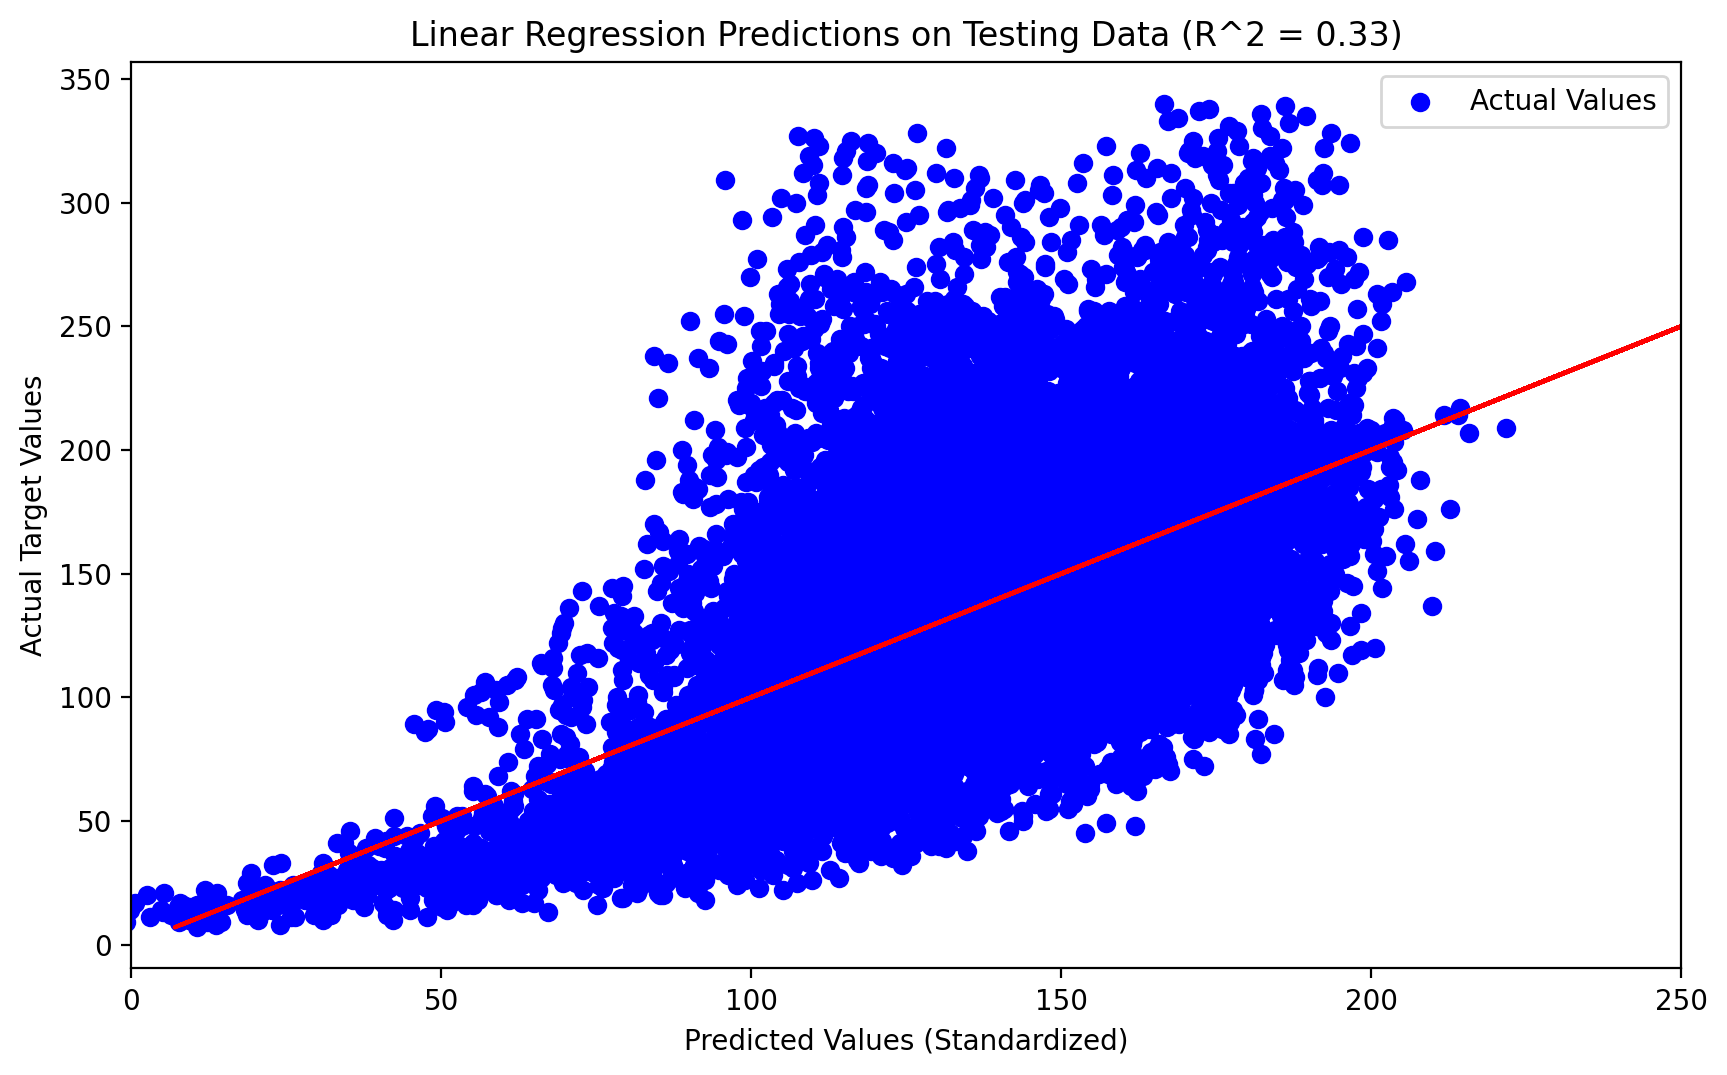

0.3265530194595688

In [207]:
Xtest = sm.add_constant(testScaled)
plt.figure(figsize=(10, 6))
plt.scatter(model.predict(Xtest), yTest, color='blue', label='Actual Values')
plt.plot(yTest.values, yTest.values, color='red')  # Line for perfect predictions

plt.title(f'Linear Regression Predictions on Testing Data (R^2 = 0.33)')
plt.xlabel('Predicted Values (Standardized)')
plt.ylabel('Actual Target Values')
plt.xlim(0, 250)  # Setting limit for x-axis
plt.legend()
plt.show()
sklearn.metrics.r2_score(yTest, model.predict(Xtest))

In [132]:
# Assuming traincleaned and testScaled are pandas DataFrames

# Convert yTrain DataFrame column to a 1-dimensional array
yTrain_reshaped = yTrain.values.flatten()  # or yTrain.to_numpy().ravel()

# Set up the LassoCV model
lasso = LassoCV(alphas=[25], cv=5, random_state=0, max_iter=10000)

# Fit the model
lasso.fit(trainScaled, yTrain_reshaped)

# Get the selected features
selected_features = np.where(lasso.coef_ != 0)[0]

# Filter the train and test datasets based on selected features
xTrainLasso = trainScaled.iloc[:, selected_features]
xTestLasso = testScaled.iloc[:, selected_features]

XtrainLasso = sm.add_constant(xTrainLasso)
modelLasso= sm.OLS(yTrain, XtrainLasso).fit()

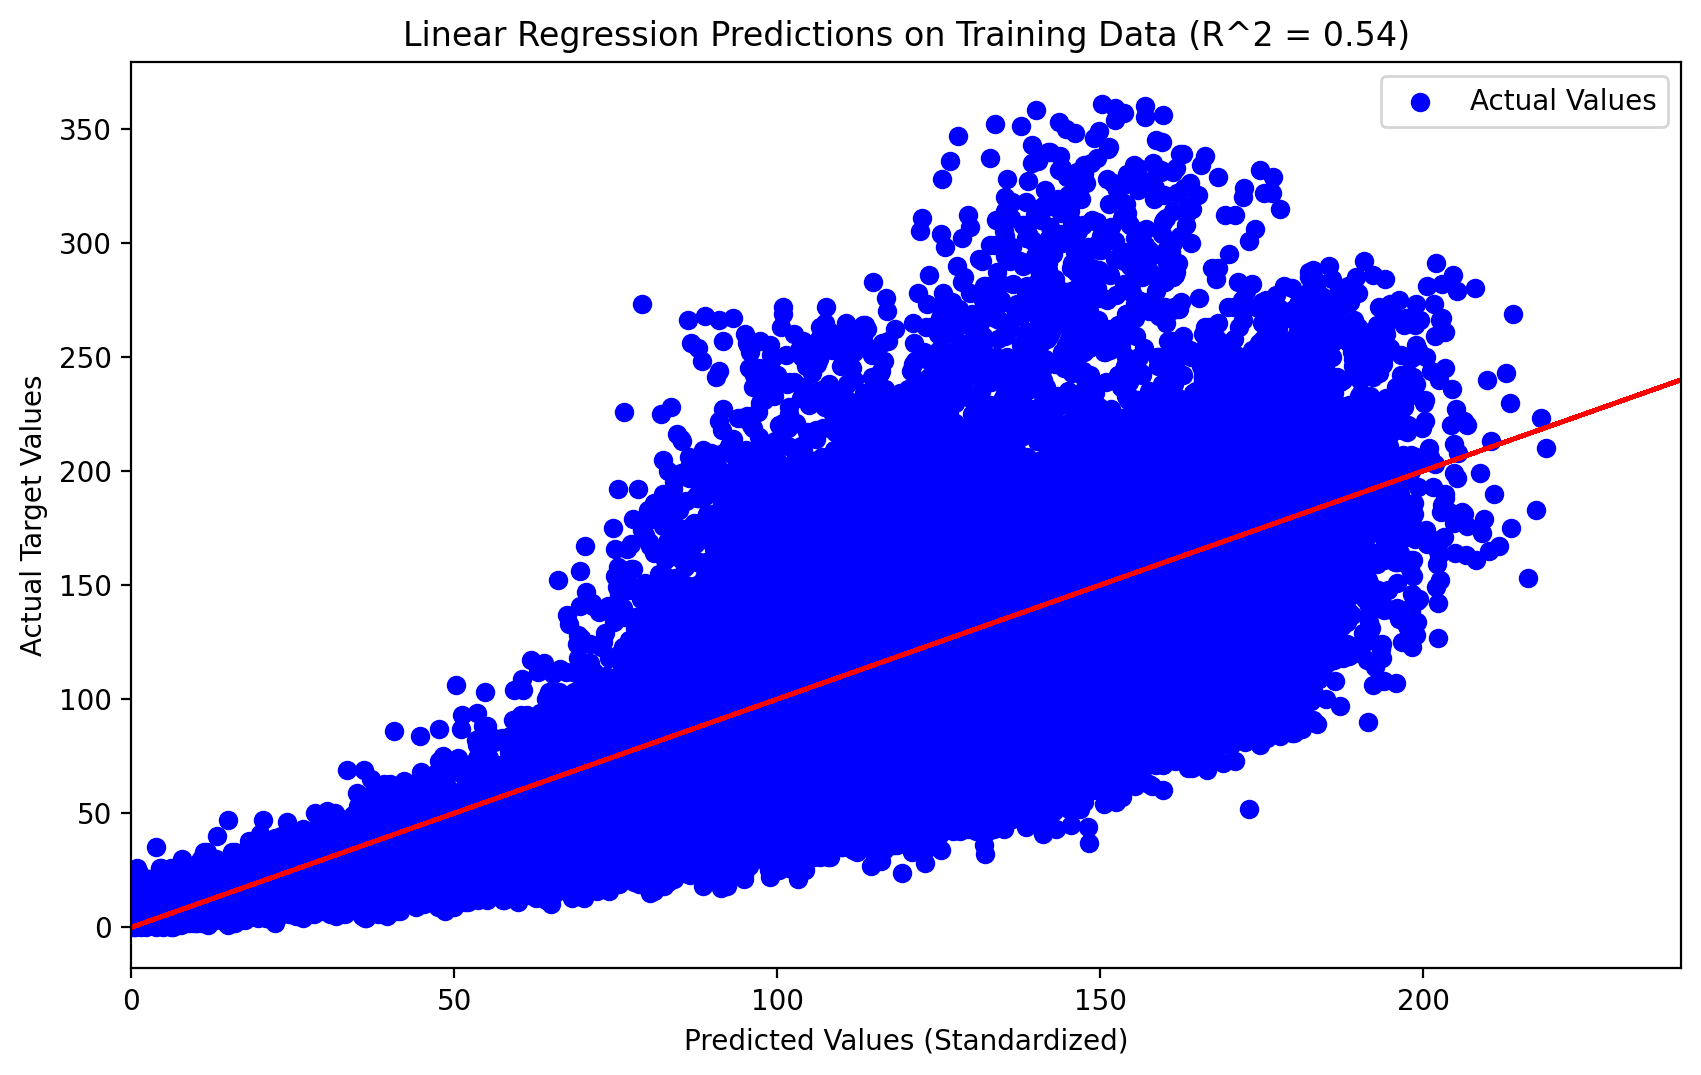

0.5369097671289964


In [204]:
r_squared = .536
plt.figure(figsize=(10, 6))
plt.scatter(modelLasso.predict(XtrainLasso), yTrain, color='blue', label='Actual Values')
plt.plot(yTrain.values, yTrain.values, color='red')  # Line for perfect predictions

plt.title(f'Linear Regression Predictions on Training Data (R^2 = {r_squared:.2f})')
plt.xlabel('Predicted Values (Standardized)')
plt.ylabel('Actual Target Values')
plt.legend()
plt.xlim(0, 240)  # Setting limit for x-axis
plt.show()
print(r2_score(yTrain, modelLasso.predict(XtrainLasso)))

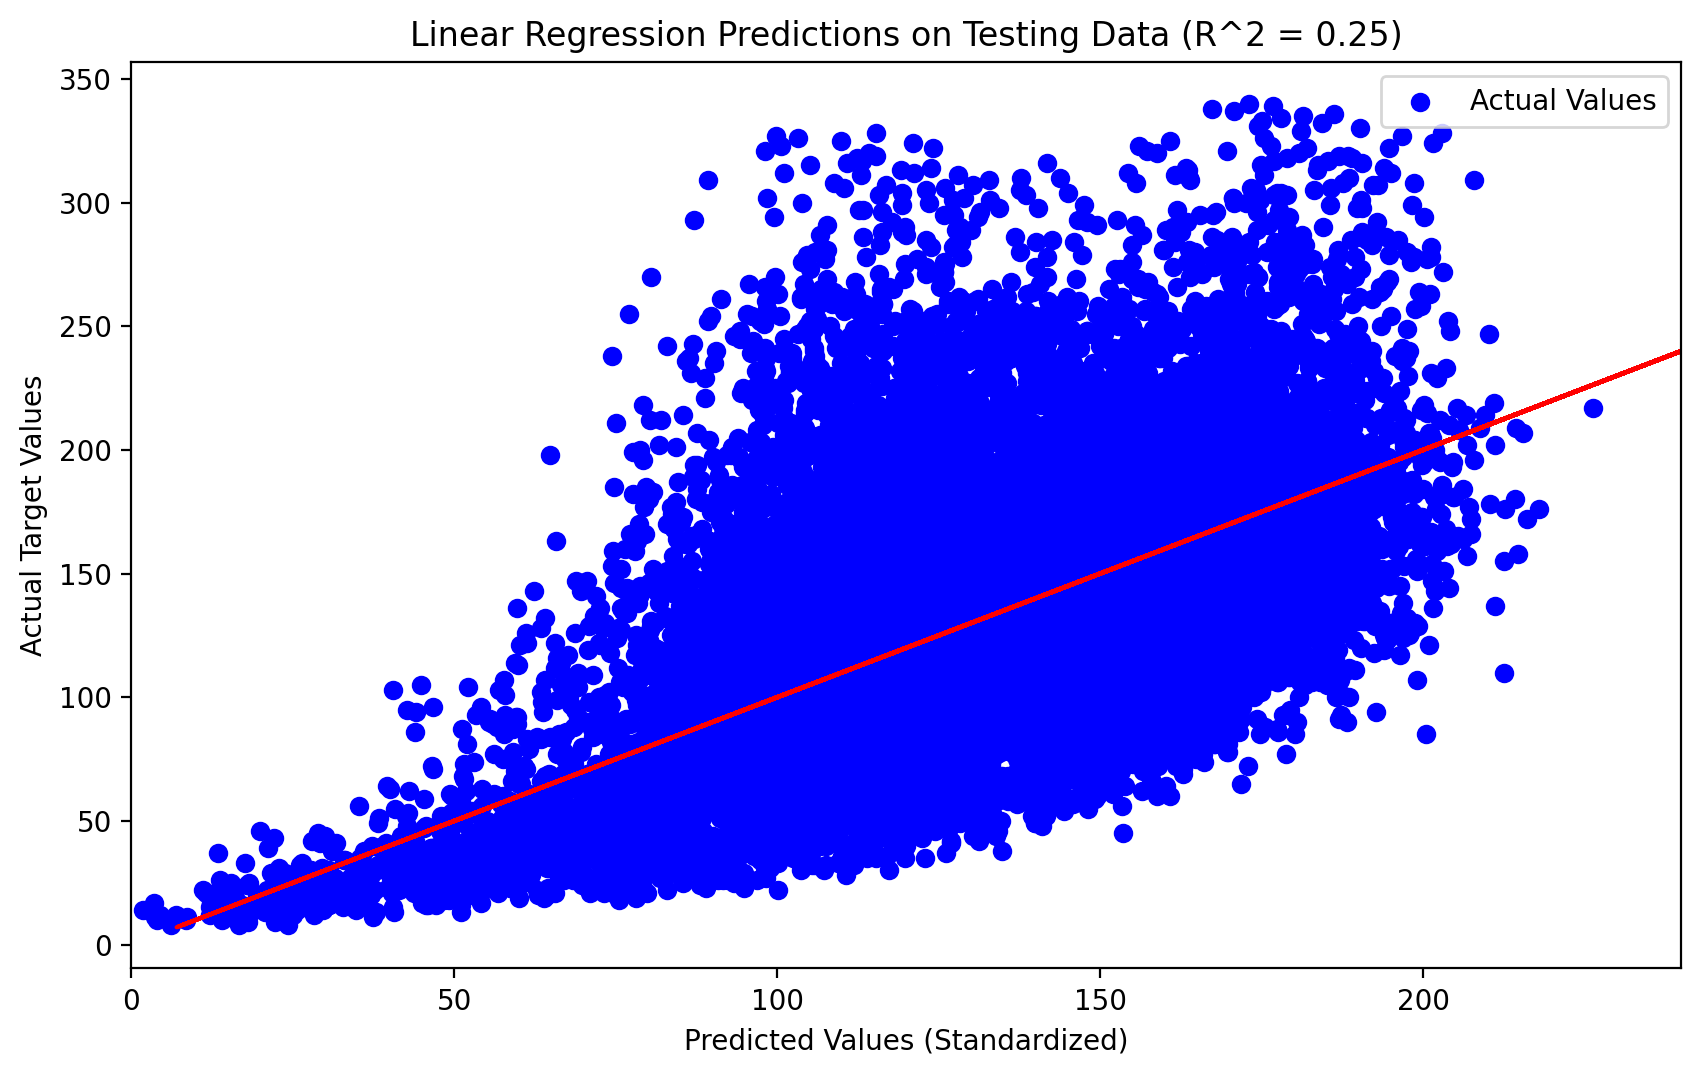

0.24685995488036894

In [206]:
XTestLasso = sm.add_constant(xTestLasso)
plt.figure(figsize=(10, 6))
plt.scatter(modelLasso.predict(XTestLasso), yTest, color='blue', label='Actual Values')
plt.plot(yTest.values, yTest.values, color='red')  # Line for perfect predictions
plt.xlim(0, 240)  # Setting limit for x-axis
plt.title(f'Linear Regression Predictions on Testing Data (R^2 = 0.25)')
plt.xlabel('Predicted Values (Standardized)')
plt.ylabel('Actual Target Values')
plt.legend()
plt.show()
sklearn.metrics.r2_score(yTest, modelLasso.predict(XTestLasso))

In [26]:
st = Stargazer([modelLasso])
HTML(st.render_html())

#### Equation: Cycles Remaining = 107.8  -13.4\*(sensor 4) + 7.4\*(sensor 7) - 16.4\*(sensor 11) + 8.2\*(sensor 12) - 9.5\*(sensor 15)
(standardized)

Sensor 4: Temperature of Low Pressure Turbine

Sensor 7: Total Pressure of High Presure Turbine

Sensor 11: Static Pressure of High Pressure Turbine

Sensor 12: Ratio of fuel flow

Sensor 15: Bypass Ratio

In [208]:
predicted_values = modelLasso.predict(XTestLasso)

# Calculating the MSE
mse = mean_squared_error(yTest, predicted_values)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2619.713468419889


In [209]:
predicted_values = model.predict(Xtest)

# Calculating the MSE
mse = mean_squared_error(yTest, predicted_values)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2342.510050581944
